In [1]:
import numpy as np
import awkward as ak
import uproot
import mplhep as hep
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pathlib import Path

%load_ext autoreload
%autoreload 2
import laserball_analysis as ana

hep.styles.use("ROOT")

In [2]:
data_directory = Path("/nfs/disk1/users/jierans/eos/eos_laserball_sims")
files = list(data_directory.glob("*.ntuple.root"))

sim_ttrees = {}
scanned_wavelengths = [374, 408, 515]
scanned_zpos = np.sort(np.arange(0, -601, -100))
for wvl in scanned_wavelengths:
    sim_ttrees[wvl] = {}
    for zpos in scanned_zpos:
        zpos_txt = f"{zpos}_up" if zpos > 0 else f"{-zpos}_down"
        fname = f"eos_pbomb_{wvl}nm_{zpos_txt}.ntuple.root"
        # print(fname)
        full_path = (data_directory/fname)
        assert full_path in files, f"Sim file not found for {fname}"
        sim_ttrees[wvl][zpos] = uproot.open(full_path.as_posix())['output']

pmtinfo = ana.PMTInfo(files[0].as_posix())

## MC

In [3]:
def get_mchits_by_lcn(mcdata):
    hit_histogram = ana.aggregate_histogram(mcdata, "mcPMTID",
                                            bin_params={"bins": np.arange(-0.5, 270.5, 1)},
                                            flat_transform_func=pmtinfo.id_to_lcn
                                            )
    return hit_histogram


bottom_8in = pmtinfo.lcn[(pmtinfo.type == 0) & (pmtinfo.z < -800)]
edges_10inch = np.arange(np.min(pmtinfo.get_lcns_by_type(3))-0.5, np.max(pmtinfo.get_lcns_by_type(3))+0.6)
bottom_8in_zpos = np.mean(pmtinfo.z[[lcn in bottom_8in for lcn in pmtinfo.lcn]])
bottom_10in_zpos = np.mean(pmtinfo.z[pmtinfo.type == 3])
print(bottom_8in_zpos, bottom_10in_zpos)

mc_nhits = {}
mc_norms = {}
for i, zpos in enumerate(scanned_zpos):
    mc_nhits[zpos] = {}
    mc_norms[zpos] = {}
    for wvl in scanned_wavelengths:
        tree = sim_ttrees[wvl][zpos]
        nhits, edges = get_mchits_by_lcn(tree)
        bottom_8in_ly = np.mean(nhits[bottom_8in])
        norm = bottom_8in_ly * (bottom_10in_zpos - zpos)**2 / (bottom_8in_zpos - zpos)**2
        mc_norms[zpos][wvl] = norm
        mc_nhits[zpos][wvl] = nhits

-1088.9178333333332 -1479.8497692307694


100%|██████████████████████████████████████████████████████| 250000/250000 [00:03<00:00, 70528.77event/s]


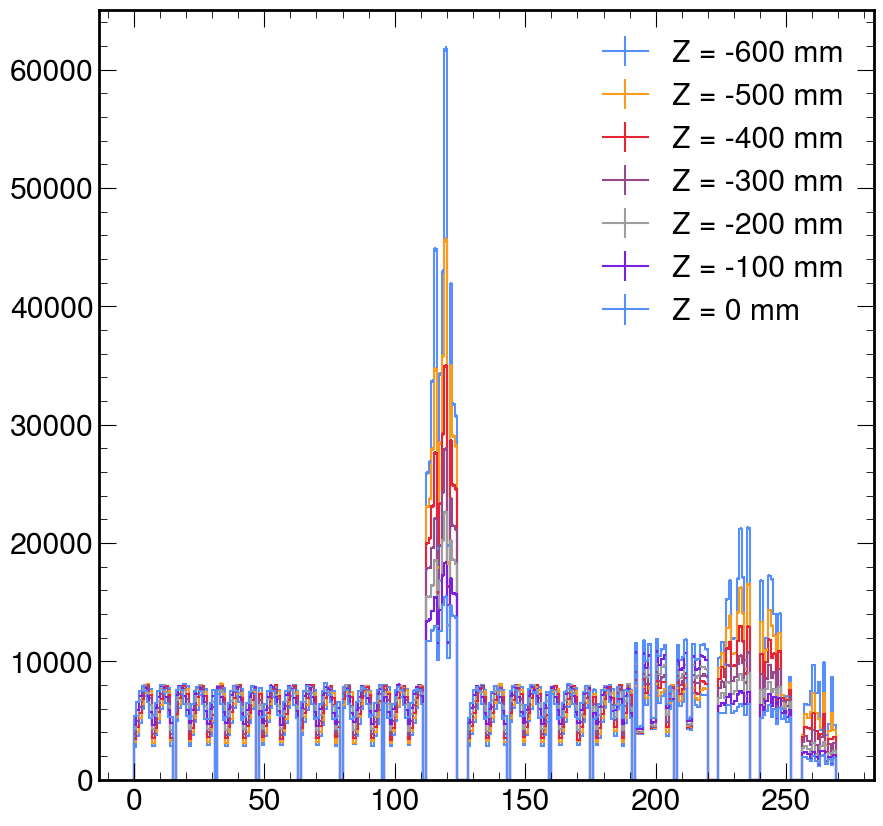

In [4]:
wvl = 515
for zpos in scanned_zpos:
    lcn_nhit = mc_nhits[zpos][wvl]
    hep.histplot(lcn_nhit, yerr=True, label=f"Z = {zpos} mm")
plt.legend()


Text(0.5, 1.0, '515 nm')

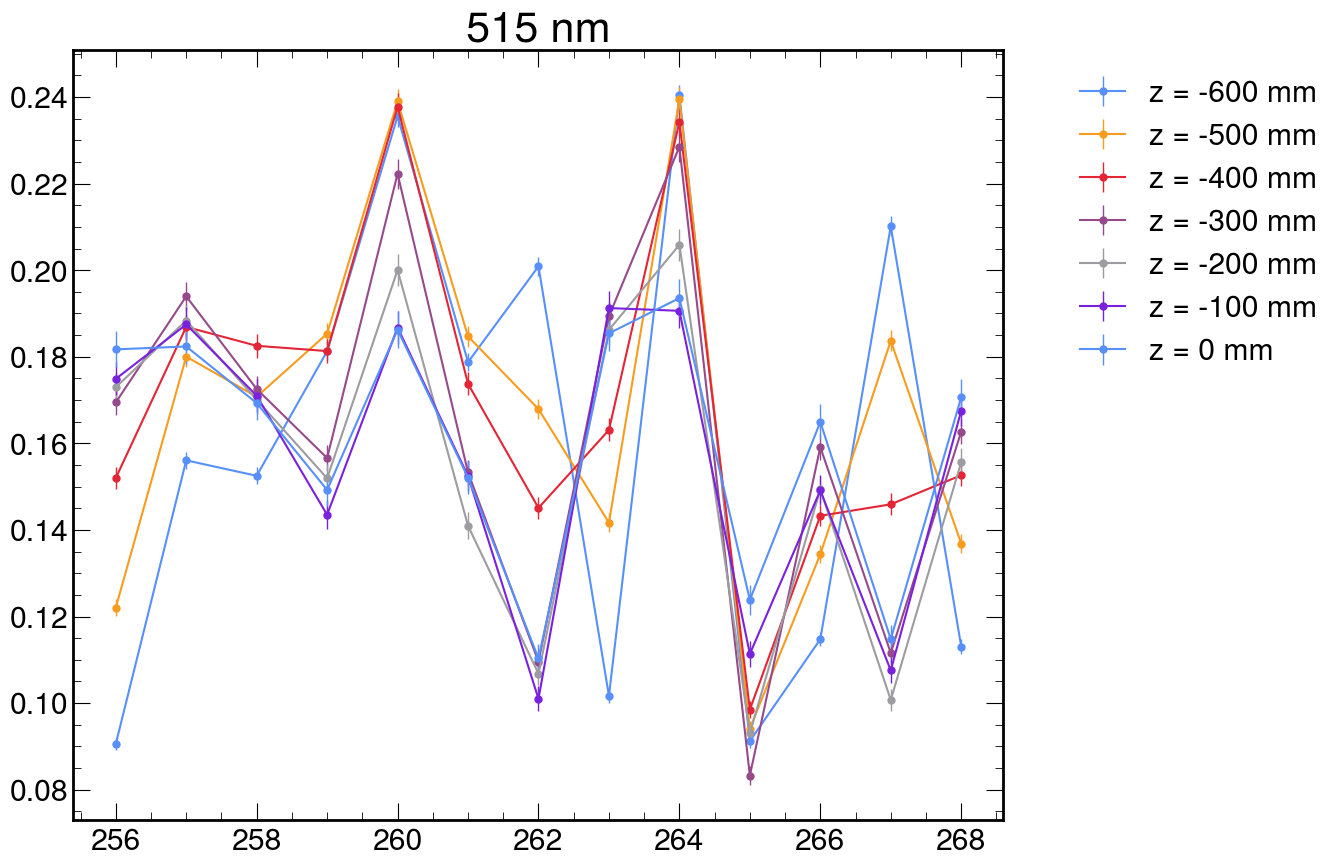

In [5]:
plt.figure(figsize=(12, 10))
for zpos in scanned_zpos:
    lcn_nhit = mc_nhits[zpos][wvl]
    norm = mc_norms[zpos][wvl]
    hep.histplot(lcn_nhit[pmtinfo.get_lcns_by_type(3)], edges_10inch, binwnorm=1/norm,
                 yerr=True, histtype='errorbar', linestyle='-',
                 label=f'z = {zpos} mm')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title(f"{wvl} nm")


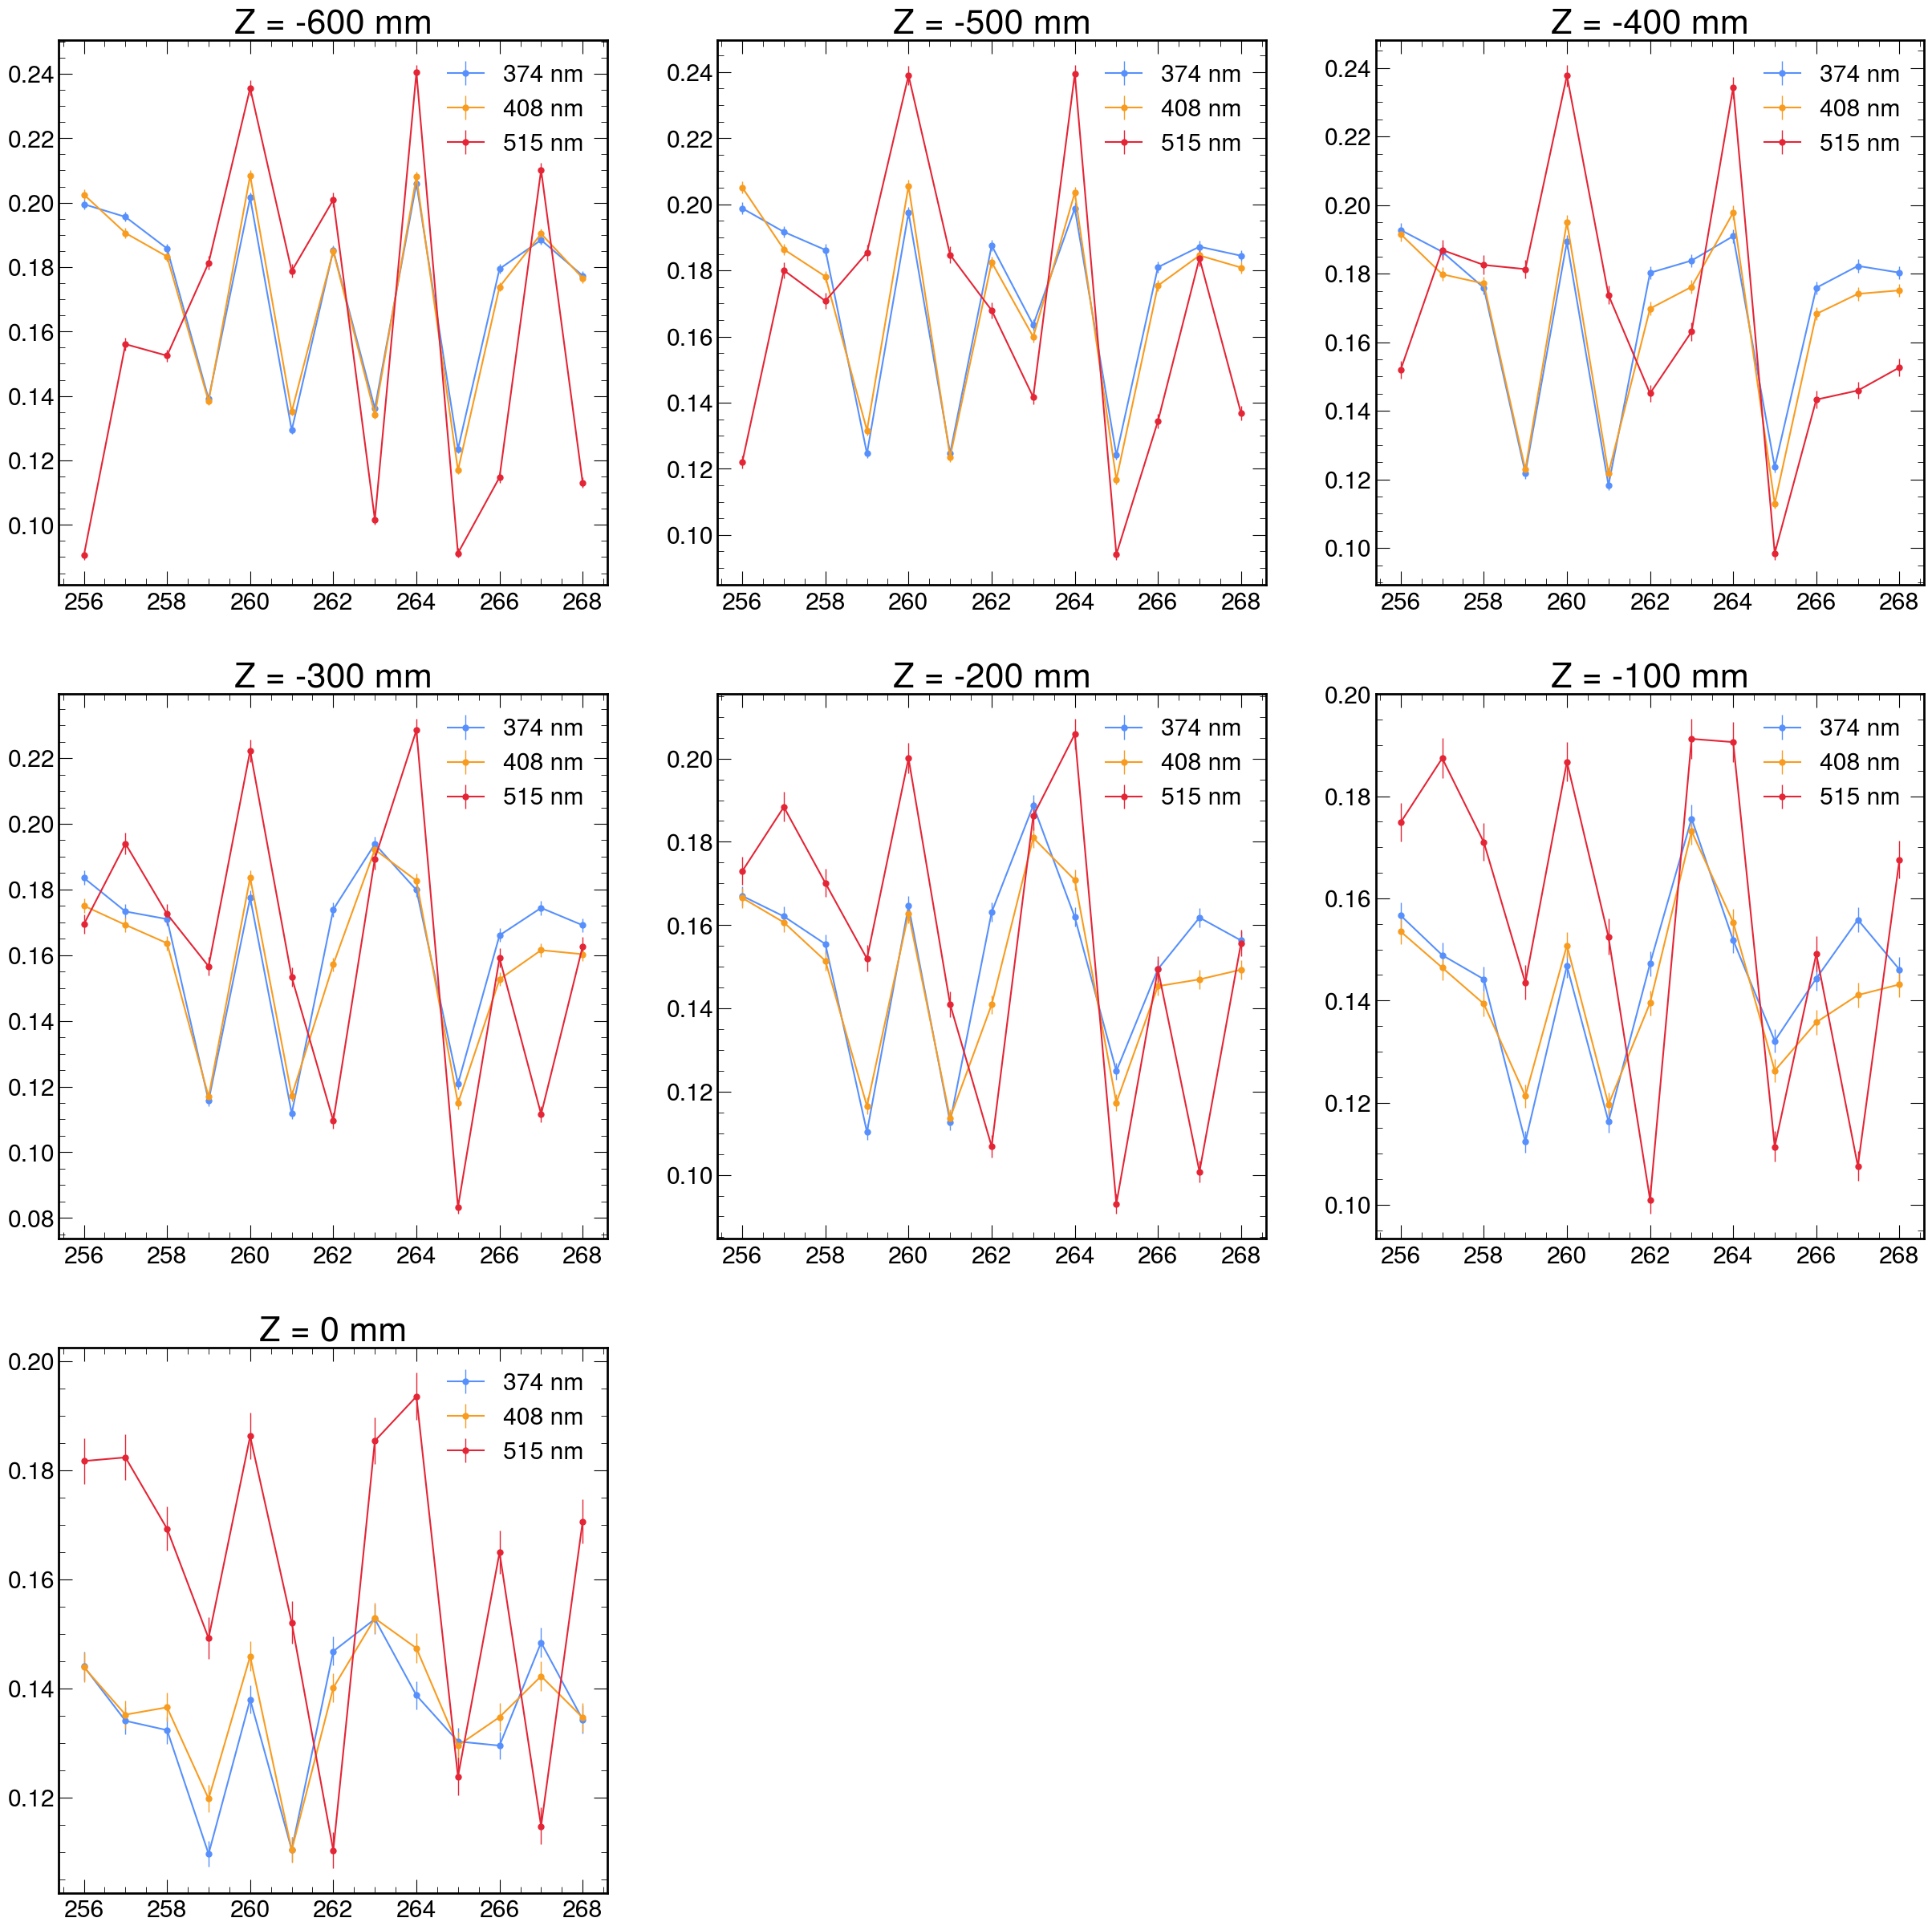

In [6]:
plt.figure(figsize=(30, 30))
for i, zpos in enumerate(scanned_zpos):
    plt.subplot(3, 3, i+1)
    for wvl in scanned_wavelengths:
        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl]
        hep.histplot(nhits[pmtinfo.get_lcns_by_type(3)], edges_10inch,
                     yerr=True, binwnorm=1/norm,
                     histtype='errorbar', linestyle='-',
                     label=f'{wvl} nm')
    plt.legend()
    plt.title(f"Z = {zpos} mm")

Text(0, 1, 'Normalized mean hit from 10in PMTs')

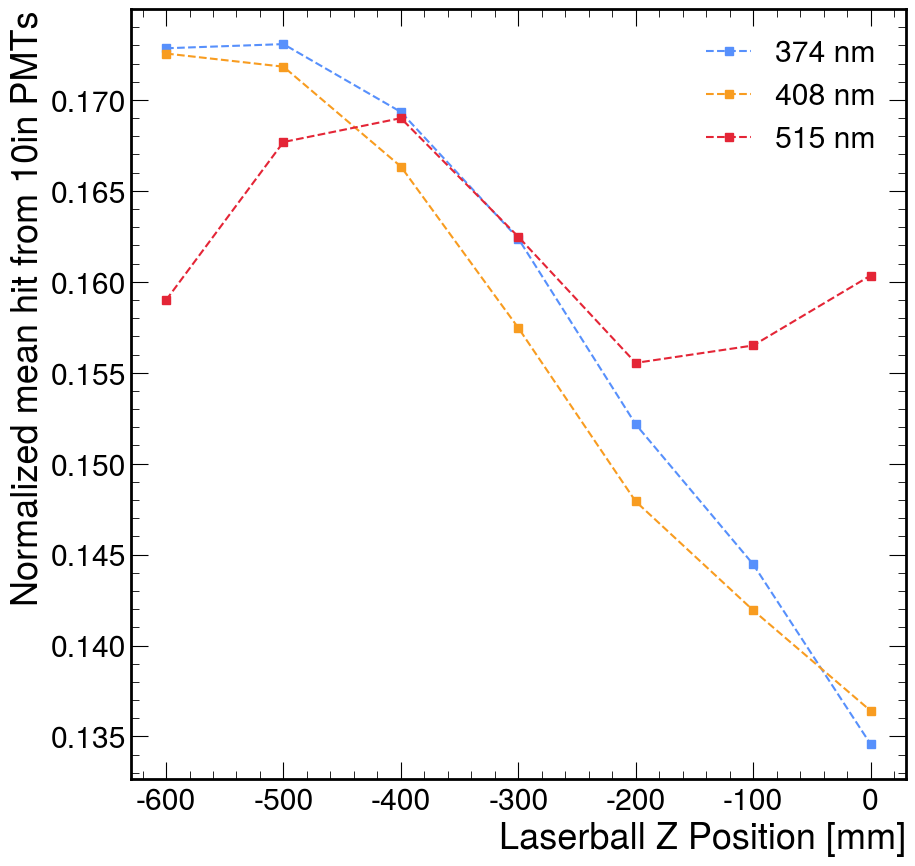

In [19]:
for wvl in scanned_wavelengths:
    mean_hits = []
    for zpos in scanned_zpos:
        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, mean_hits, 's--', label=f'{wvl} nm')
    # break
plt.legend()
plt.xlabel("Laserball Z Position [mm]")
plt.ylabel("Normalized mean hit from 10in PMTs")

Text(0, 1, 'Normalized mean hit from 10in PMTs')

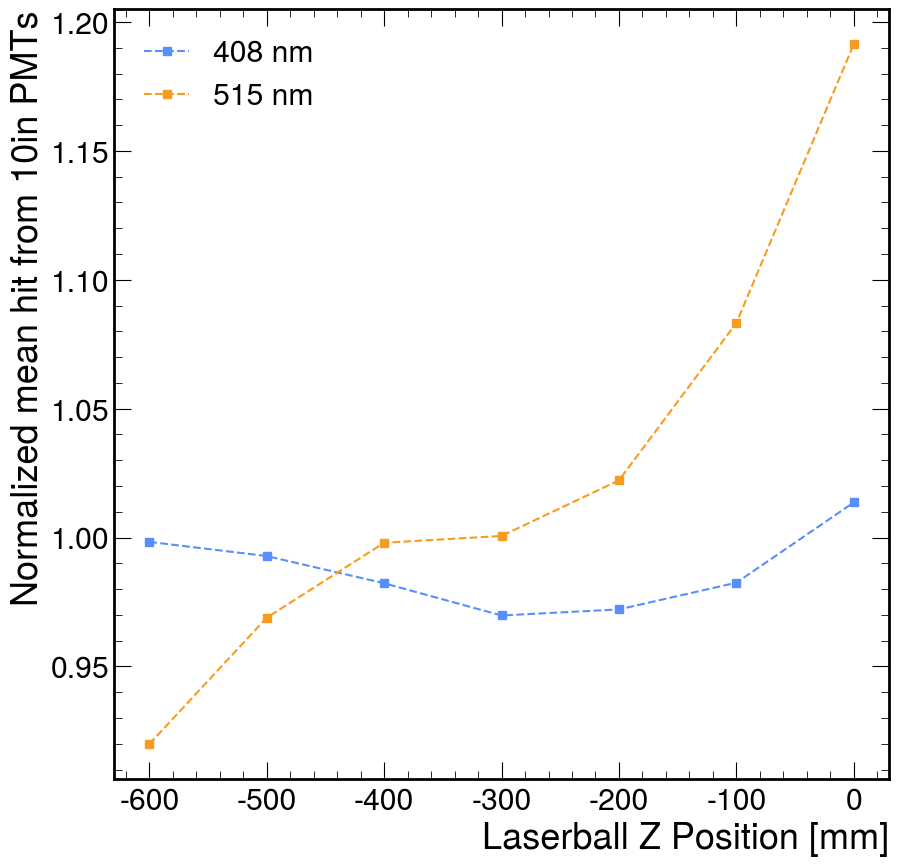

In [33]:
wvl = 374
mean_hits_374nm = []
for zpos in scanned_zpos:
    norm = mc_norms[zpos][wvl]
    nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
    mean_hits_374nm.append(np.mean(nhits) / norm)


for wvl in scanned_wavelengths:
    if wvl == 374: continue
    mean_hits = []
    for zpos in scanned_zpos:
        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, np.asarray(mean_hits) / np.asarray(mean_hits_374nm), 's--', label=f'{wvl} nm')
    # break
plt.legend()
plt.xlabel("Laserball Z Position [mm]")
plt.ylabel("Normalized mean hit from 10in PMTs")

## DATA

In [20]:
data_ttrees = {}
data_dir = "/nfs/disk1/eos/gold_run_ntuples"
data_ttrees[374] = {}
data_ttrees[374][0]    = f"{data_dir}/run330/*.ntuple.root:output"
data_ttrees[374][-100] = f"{data_dir}/run328/*.ntuple.root:output"
data_ttrees[374][-200] = f"{data_dir}/run326/*.ntuple.root:output"
data_ttrees[374][-300] = f"{data_dir}/run325/*.ntuple.root:output"
data_ttrees[374][-400] = f"{data_dir}/run324/*.ntuple.root:output"
data_ttrees[374][-500] = f"{data_dir}/run323/*.ntuple.root:output"
data_ttrees[374][-600] = f"{data_dir}/run322/*.ntuple.root:output"

data_ttrees[408] = {}
data_ttrees[408][0]    = f"{data_dir}/run273/*.ntuple.root:output"
data_ttrees[408][-100] = f"{data_dir}/run274/*.ntuple.root:output"
data_ttrees[408][-200] = f"{data_dir}/run275/*.ntuple.root:output"
data_ttrees[408][-300] = f"{data_dir}/run276/*.ntuple.root:output"
data_ttrees[408][-400] = f"{data_dir}/run277/*.ntuple.root:output"
data_ttrees[408][-500] = f"{data_dir}/run278/*.ntuple.root:output"
data_ttrees[408][-600] = f"{data_dir}/run279/*.ntuple.root:output"

data_ttrees[515] = {}
data_ttrees[515][0]    = f"{data_dir}/run149/*.ntuple.root:output"
data_ttrees[515][-100] = f"{data_dir}/run150/*.ntuple.root:output"
data_ttrees[515][-200] = f"{data_dir}/run151/*.ntuple.root:output"
data_ttrees[515][-300] = f"{data_dir}/run152/*.ntuple.root:output"
data_ttrees[515][-400] = f"{data_dir}/run153/*.ntuple.root:output"
data_ttrees[515][-500] = f"{data_dir}/run154/*.ntuple.root:output"
data_ttrees[515][-600] = f"{data_dir}/run155/*.ntuple.root:output"

In [24]:
def get_datahits_by_lcn(data):
    hit_histogram = ana.aggregate_histogram(data, "digitPMTID",
                                            expressions=["digitNCrossings", "digitPMTID"],
                                            bin_params={"bins": np.arange(-0.5, 270.5, 1)},
                                            flat_transform_func=pmtinfo.id_to_lcn,
                                            cut_func=lambda batch: batch['digitNCrossings'] == 1,
                                            )
    return hit_histogram


bottom_8in = pmtinfo.lcn[(pmtinfo.type == 0) & (pmtinfo.z < -800)]
edges_10inch = np.arange(np.min(pmtinfo.get_lcns_by_type(3))-0.5, np.max(pmtinfo.get_lcns_by_type(3))+0.6)
bottom_8in_zpos = np.mean(pmtinfo.z[[lcn in bottom_8in for lcn in pmtinfo.lcn]])
bottom_10in_zpos = np.mean(pmtinfo.z[pmtinfo.type == 3])
# print(bottom_8in_zpos, bottom_10in_zpos)

data_nhits = {}
data_norms = {}
for i, zpos in enumerate(scanned_zpos):
    data_nhits[zpos] = {}
    data_norms[zpos] = {}
    for wvl in scanned_wavelengths:
        tree = data_ttrees[wvl][zpos]
        nhits, edges = get_datahits_by_lcn(tree)
        bottom_8in_ly = np.mean(nhits[bottom_8in])
        norm = bottom_8in_ly * (bottom_10in_zpos - zpos)**2 / (bottom_8in_zpos - zpos)**2
        data_norms[zpos][wvl] = norm
        data_nhits[zpos][wvl] = nhits

100%|██████████████████████████████████████████████████████| 499224/499224 [00:27<00:00, 17867.55event/s]


In [25]:
import pickle
with open('/home/jierans/work/eos/laserball_nhits.pickle', 'wb') as f:
    pickle.dump([data_nhits, data_norms], f)

In [26]:
import pickle
with open('/home/jierans/work/eos/laserball_nhits.pickle', 'rb') as f:
    data_nhits, data_norms = pickle.load(f)

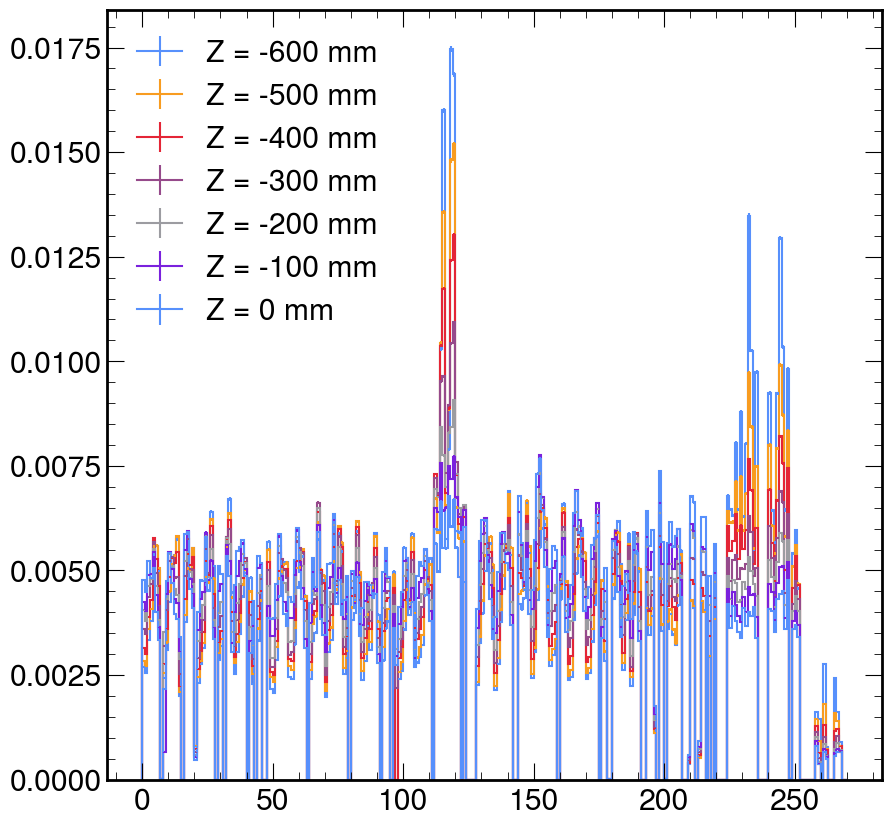

In [27]:
wvl = 515
for zpos in scanned_zpos:
    lcn_nhit = data_nhits[zpos][wvl]
    hep.histplot(lcn_nhit, yerr=True, label=f"Z = {zpos} mm", density=True)
plt.legend()


Text(0.5, 1.0, '515 nm')

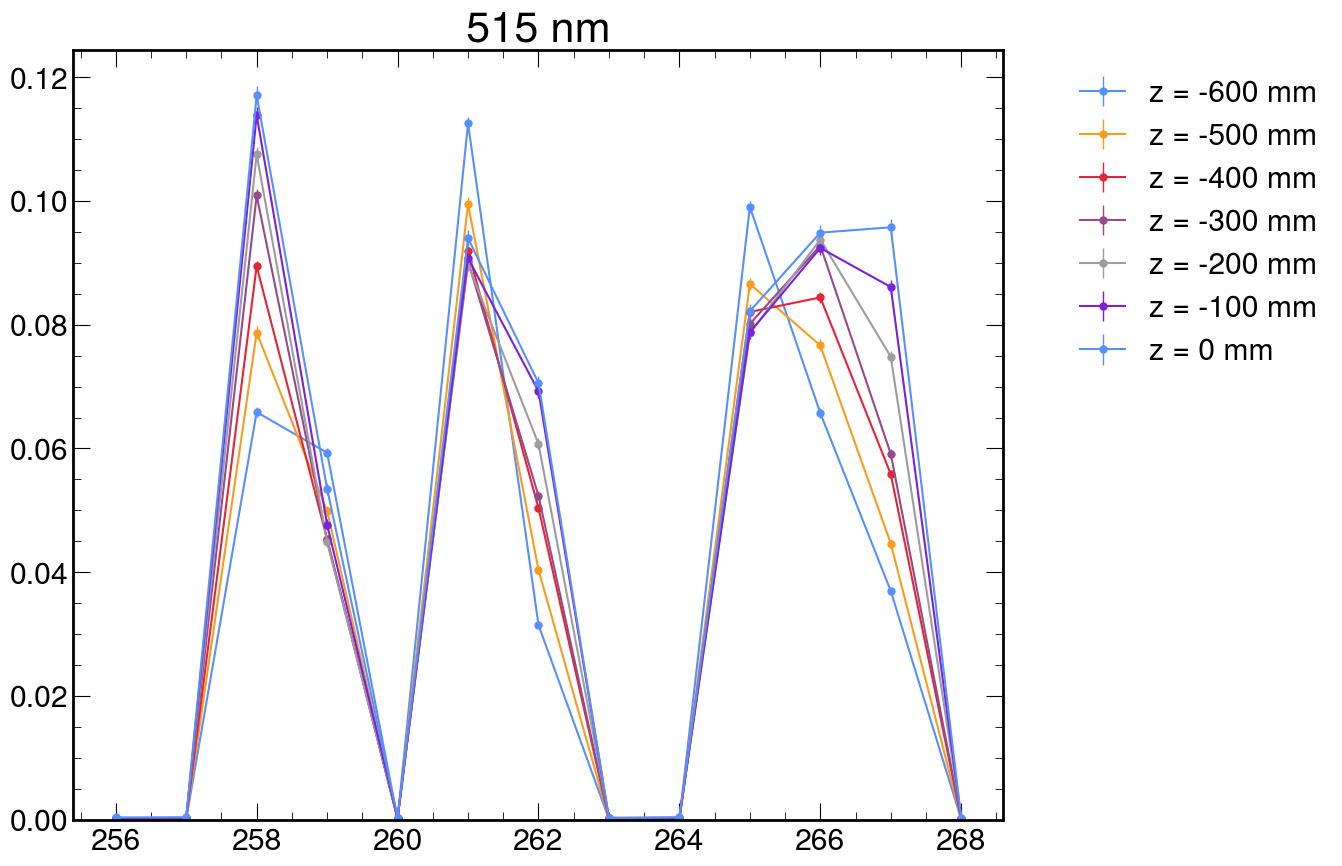

In [28]:
plt.figure(figsize=(12, 10))
for zpos in scanned_zpos:
    lcn_nhit = data_nhits[zpos][wvl]
    norm = data_norms[zpos][wvl]
    hep.histplot(lcn_nhit[pmtinfo.get_lcns_by_type(3)], edges_10inch, binwnorm=1/norm,
                 yerr=True, histtype='errorbar', linestyle='-',
                 label=f'z = {zpos} mm')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title(f"{wvl} nm")


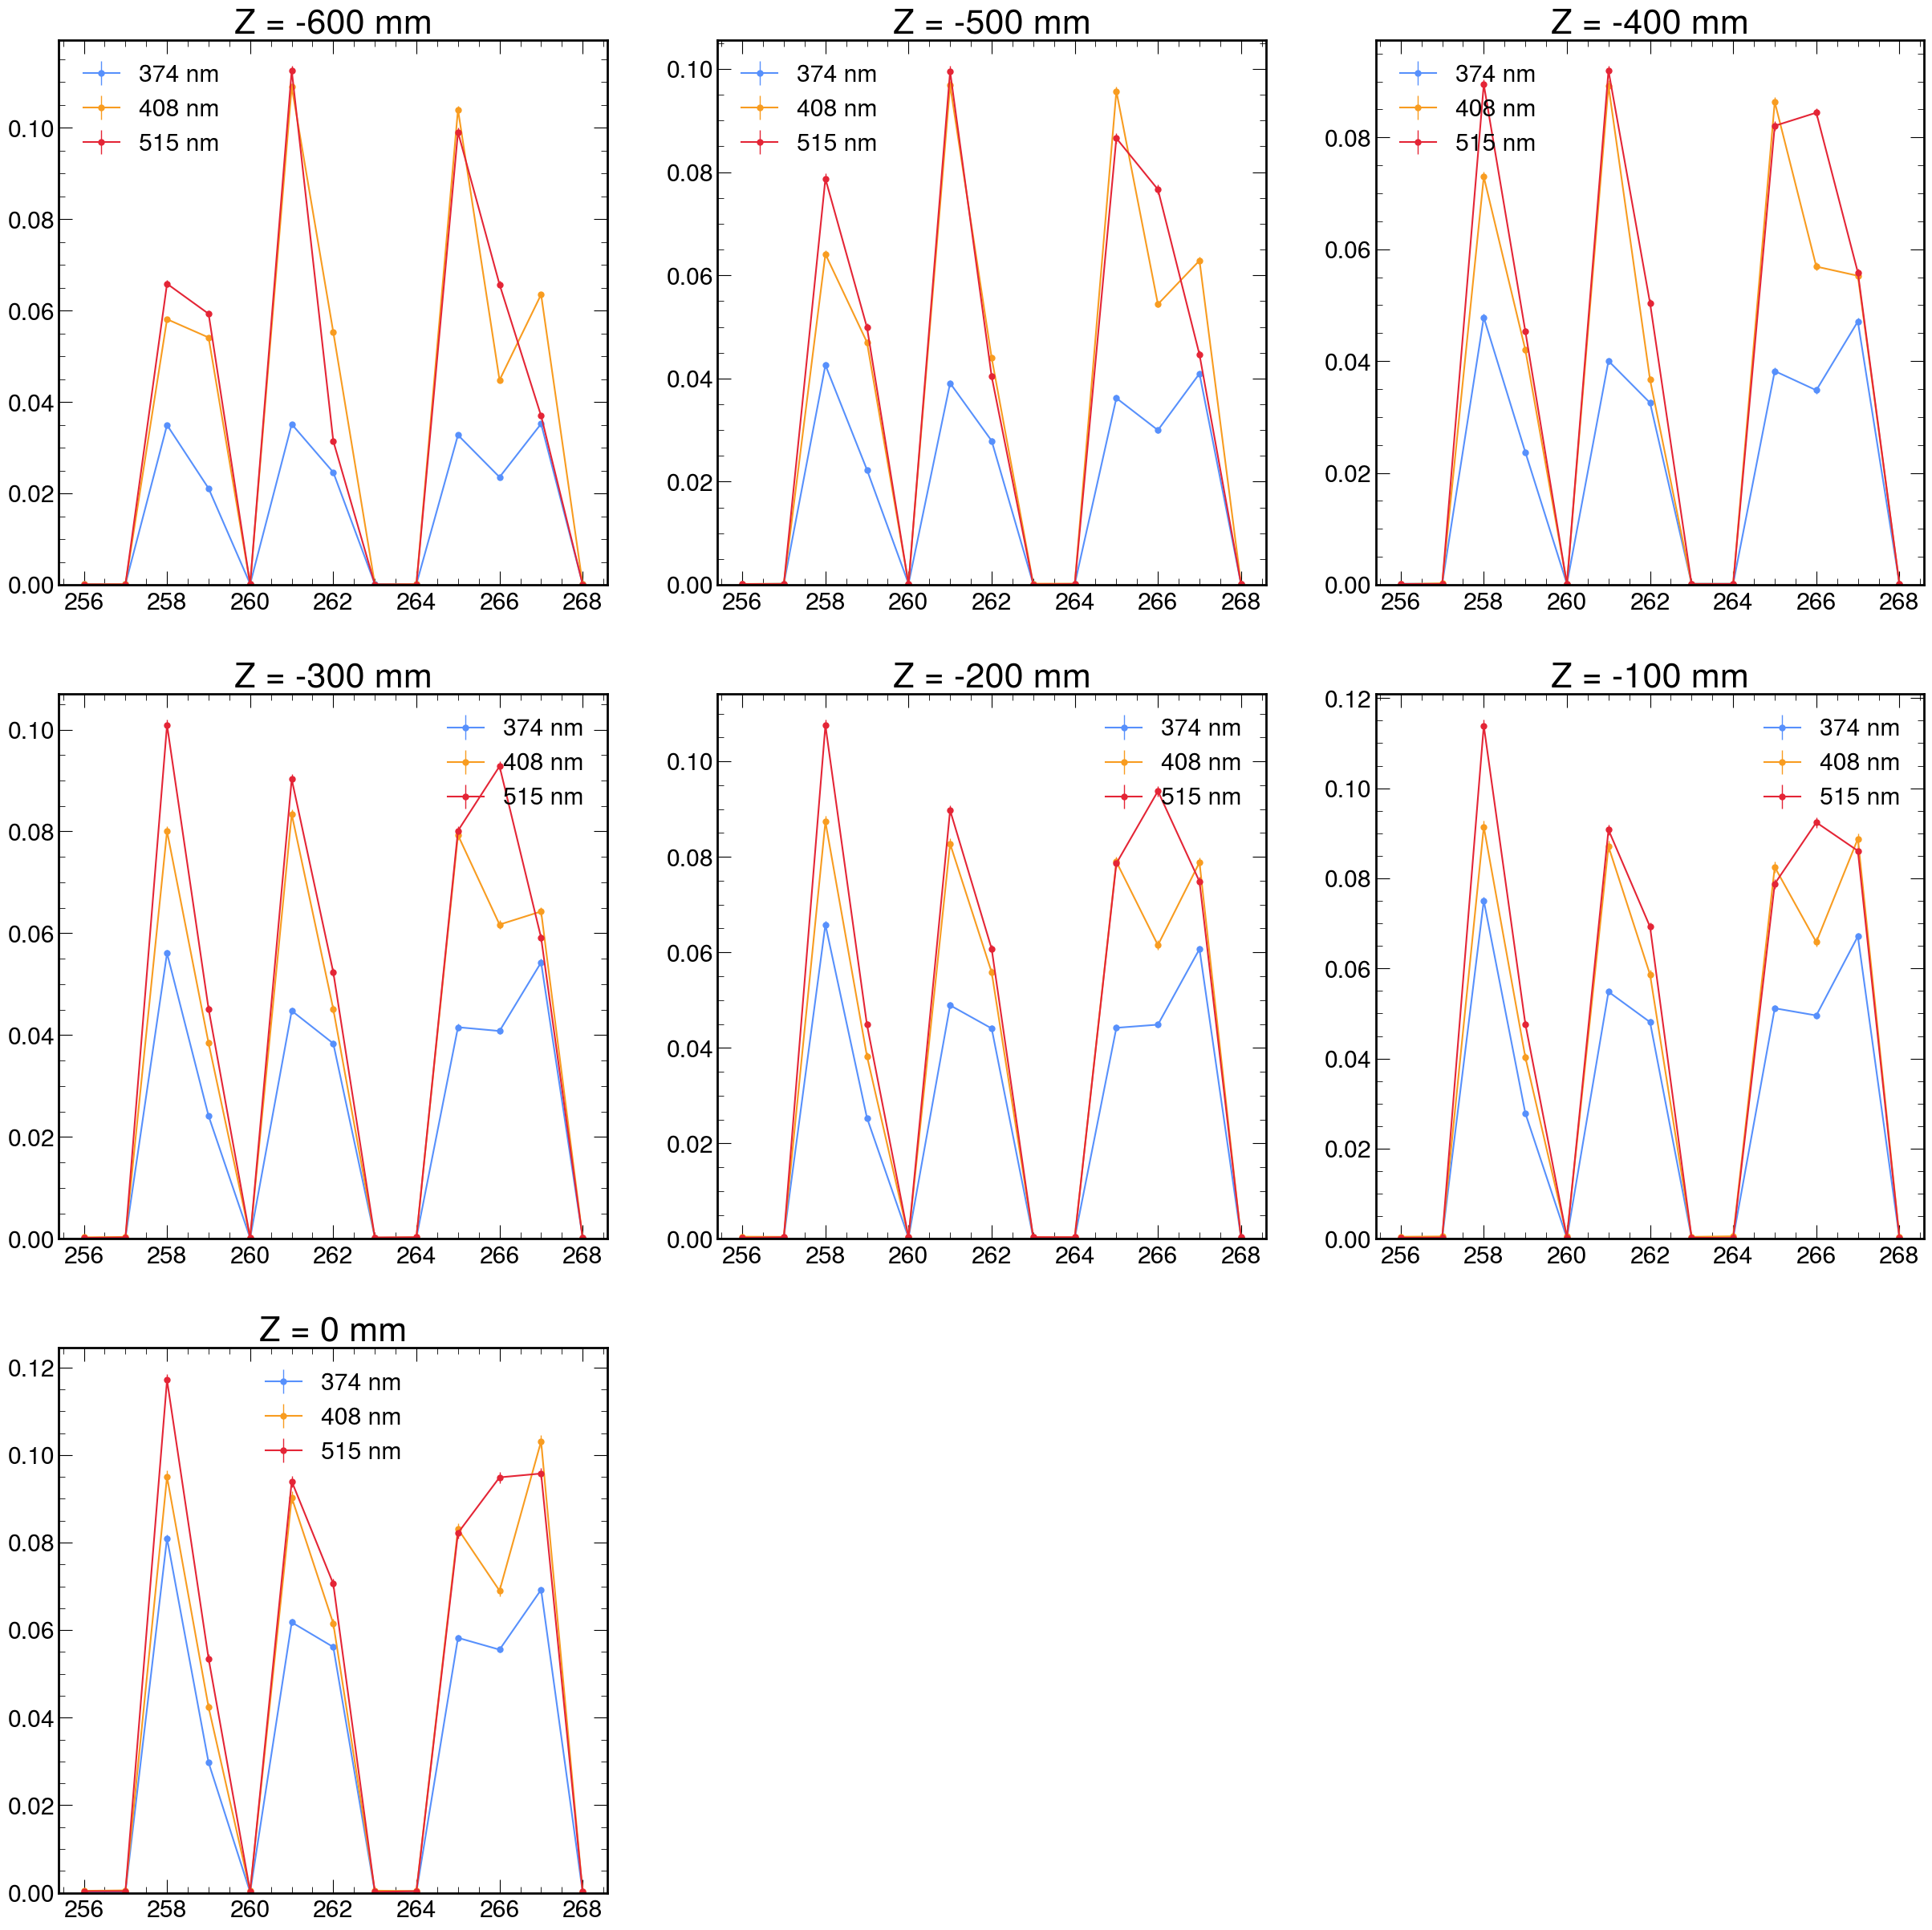

In [29]:
plt.figure(figsize=(30, 30))
for i, zpos in enumerate(scanned_zpos):
    plt.subplot(3, 3, i+1)
    for wvl in scanned_wavelengths:
        norm = data_norms[zpos][wvl]
        nhits = data_nhits[zpos][wvl]
        hep.histplot(nhits[pmtinfo.get_lcns_by_type(3)], edges_10inch,
                     yerr=True, binwnorm=1/norm,
                     histtype='errorbar', linestyle='-',
                     label=f'{wvl} nm')
    plt.legend()
    plt.title(f"Z = {zpos} mm")

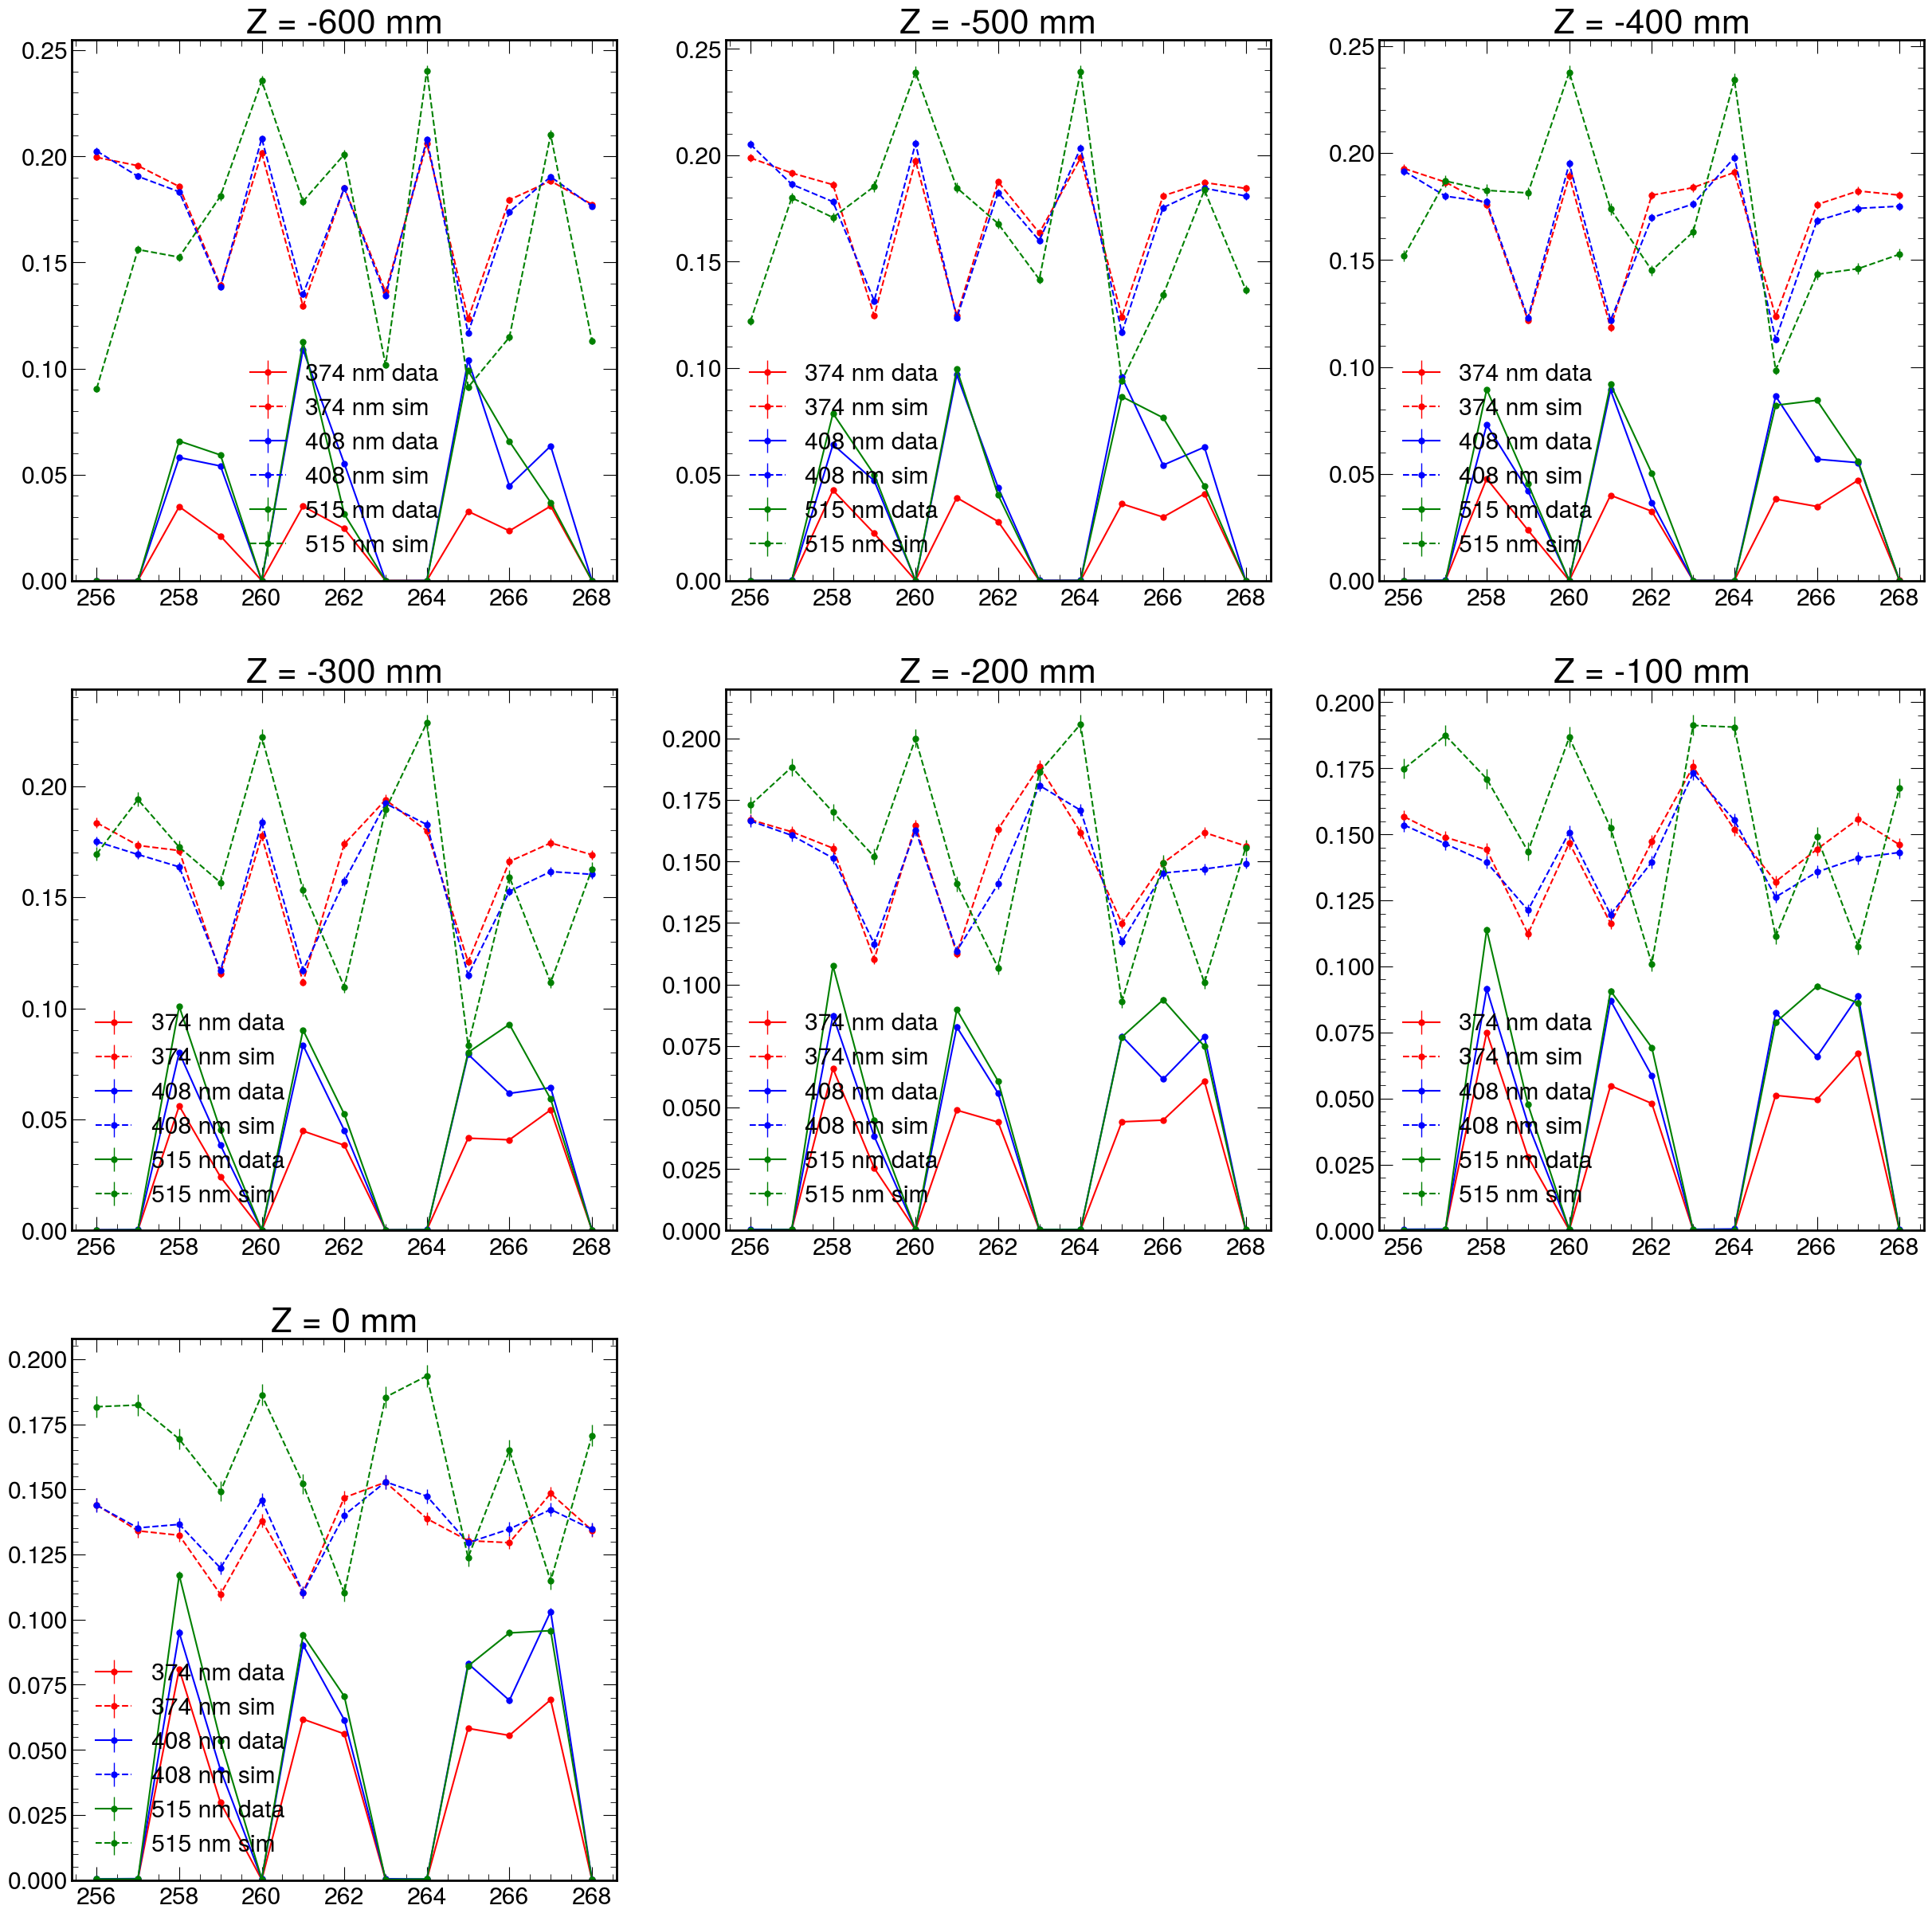

In [46]:
plt.figure(figsize=(30, 30))
colors = ['r', 'b', 'g']
for i, zpos in enumerate(scanned_zpos):
    plt.subplot(3, 3, i+1)
    for j, wvl in enumerate(scanned_wavelengths):
        norm = data_norms[zpos][wvl]
        nhits = data_nhits[zpos][wvl]
        hep.histplot(nhits[pmtinfo.get_lcns_by_type(3)], edges_10inch,
                     yerr=True, binwnorm=1/norm,
                     histtype='errorbar', linestyle='-', color=colors[j],
                     label=f'{wvl} nm data')

        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl]
        hep.histplot(nhits[pmtinfo.get_lcns_by_type(3)], edges_10inch,
                     yerr=True, binwnorm=1/norm,
                     histtype='errorbar', linestyle='--', color=colors[j],
                     label=f'{wvl} nm sim')
    plt.legend()
    plt.title(f"Z = {zpos} mm")

Text(0, 1, 'Normalized mean hit from 10in PMTs')

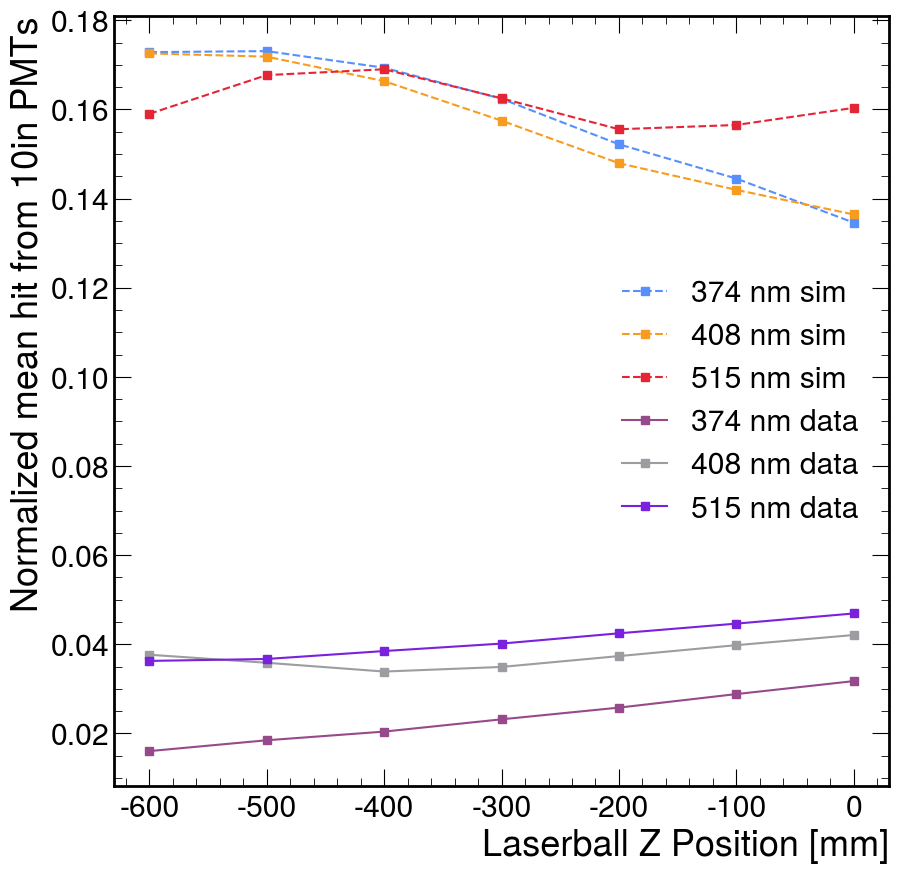

In [32]:
for wvl in scanned_wavelengths:
    mean_hits = []
    for zpos in scanned_zpos:
        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, mean_hits, 's--', label=f'{wvl} nm sim')
    # break
plt.legend()
# plt.xlabel("Laserball Z Position [mm]")
# plt.ylabel("Normalized mean hit from 10in PMTs")

for wvl in scanned_wavelengths:
    mean_hits = []
    for zpos in scanned_zpos:
        norm = data_norms[zpos][wvl]
        nhits = data_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, mean_hits, 's-', label=f'{wvl} nm data')
    # break
plt.legend()
plt.xlabel("Laserball Z Position [mm]")
plt.ylabel("Normalized mean hit from 10in PMTs")

Text(0, 1, 'Normalized mean hit from 10in PMTs')

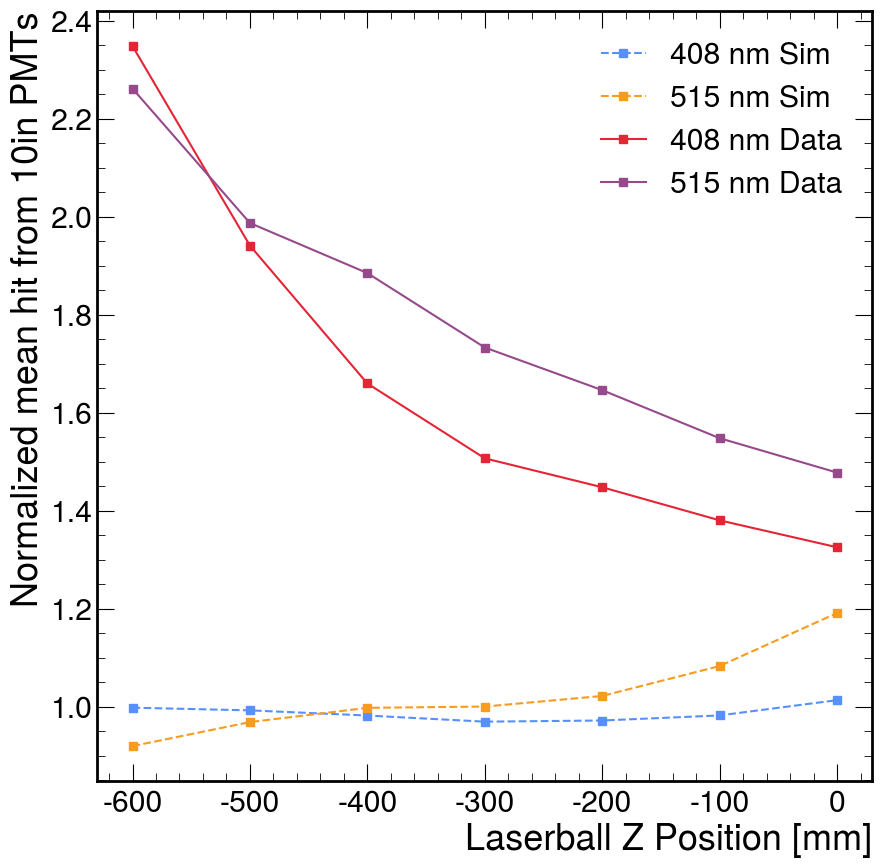

In [40]:
norm_wrt = 374

wvl = norm_wrt
mean_hits_374nm = []
for zpos in scanned_zpos:
    norm = mc_norms[zpos][wvl]
    nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
    mean_hits_374nm.append(np.mean(nhits) / norm)


for wvl in scanned_wavelengths:
    if wvl == norm_wrt: continue
    mean_hits = []
    for zpos in scanned_zpos:
        norm = mc_norms[zpos][wvl]
        nhits = mc_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, np.asarray(mean_hits) / np.asarray(mean_hits_374nm), 's--', label=f'{wvl} nm Sim')
    # break

wvl = norm_wrt
mean_hits_374nm = []
for zpos in scanned_zpos:
    norm = data_norms[zpos][wvl]
    nhits = data_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
    mean_hits_374nm.append(np.mean(nhits) / norm)


for wvl in scanned_wavelengths:
    if wvl == norm_wrt: continue
    mean_hits = []
    for zpos in scanned_zpos:
        norm = data_norms[zpos][wvl]
        nhits = data_nhits[zpos][wvl][pmtinfo.get_lcns_by_type(3)]
        # print(wvl, zpos, np.mean(nhits)/norm)
        mean_hits.append(np.mean(nhits) / norm)
    plt.plot(scanned_zpos, np.asarray(mean_hits) / np.asarray(mean_hits_374nm), 's-', label=f'{wvl} nm Data')

plt.legend()
plt.xlabel("Laserball Z Position [mm]")
plt.ylabel("Normalized mean hit from 10in PMTs")